<a href="https://colab.research.google.com/github/adefgreen98/NLU2021-Assignment2/blob/main/code/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Understanding 2021 - Assignment 2: NERs & Dependency Parsing

_Federico Pedeni, 223993_

### Setup

The following cells are needed in order to perform automatic creation of the correct directory structure. Please deactivate it in case this is not desired.

In [1]:
!git clone https://github.com/adefgreen98/NLU2021-Assignment2.git
!mv NLU2021-Assignment2/code/conll.py ./

Cloning into 'NLU2021-Assignment2'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 59 (delta 13), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (59/59), done.


In [2]:
import zipfile
import os

# Extract assignment data
if not os.path.exists('data'):
    with zipfile.ZipFile("NLU2021-Assignment2/data/conll2003.zip") as zipref:
        zipref.extractall('data')

### Requirements

In [3]:
# Needed to update spacy in Google Colab

# !pip install --upgrade spacy

In [4]:
import itertools 

import spacy
import pandas as pd
import seaborn as sn
import sklearn
from sklearn.metrics import classification_report

from conll import *

In [5]:

!python -m spacy download en_core_web_sm

if spacy.__version__.startswith('3'):
    nlp = spacy.load('en_core_web_sm')
else:
    nlp = spacy.load('en')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


### Named entity lanbels conversion from SpaCy format to CoNLL format

SpaCy uses a much wider set of labels compared to the general CoNLL 4 tags. So, in order to evaluate SpaCy's parser performance, SpaCy entity tags must be converted to the CoNLL format. At this purpose, a dictionary containing a label map is declared below, which is going to be used over the execution. 

However, the assignment of new labels has been arbitrarily defined, since there is no official information on how to perform it. The map has been created following general information on CoNLL 2003 labels that can be found [here](https://www.clips.uantwerpen.be/conll2003/ner/annotation.txt). 

The following cell has been used to gather information for label conversions.

In [6]:
if spacy.__version__.startswith('3'):
    for el in nlp.meta["labels"]["ner"]:
        print(el, ": ", spacy.explain(el))
else:
    for el in nlp.entity.labels:
        print(el, ": ", spacy.explain(el))
    
for el in nlp.meta["labels"]["ner"]:
    print(el, ": ", spacy.explain(el))

CARDINAL :  Numerals that do not fall under another type
DATE :  Absolute or relative dates or periods
EVENT :  Named hurricanes, battles, wars, sports events, etc.
FAC :  Buildings, airports, highways, bridges, etc.
GPE :  Countries, cities, states
LANGUAGE :  Any named language
LAW :  Named documents made into laws.
LOC :  Non-GPE locations, mountain ranges, bodies of water
MONEY :  Monetary values, including unit
NORP :  Nationalities or religious or political groups
ORDINAL :  "first", "second", etc.
ORG :  Companies, agencies, institutions, etc.
PERCENT :  Percentage, including "%"
PERSON :  People, including fictional
PRODUCT :  Objects, vehicles, foods, etc. (not services)
QUANTITY :  Measurements, as of weight or distance
TIME :  Times smaller than a day
WORK_OF_ART :  Titles of books, songs, etc.
CARDINAL :  Numerals that do not fall under another type
DATE :  Absolute or relative dates or periods
EVENT :  Named hurricanes, battles, wars, sports events, etc.
FAC :  Buildings, 

In [7]:

# Labelmaps converted to CoNLL according to https://www.clips.uantwerpen.be/conll2003/ner/annotation.txt
labelmap = {
    'CARDINAL': 'out',
    'DATE': 'out',
    'EVENT': 'MISC',
    'FAC': 'LOC',
    'GPE': 'LOC',
    'LANGUAGE': 'MISC',
    'LAW': 'out',
    'LOC': 'LOC',
    'MONEY': 'out',
    'NORP': 'MISC',
    'ORDINAL': 'out',
    'ORG': 'ORG',
    'PERCENT': 'out',
    'PERSON': 'PER',
    'PRODUCT': 'out',
    'QUANTITY': 'out',
    'TIME': 'out',
    'WORK_OF_ART': 'out',
    '': 'out' # label for tokens that are not part of entities
}

def convert_tag(tk:spacy.tokens.Token):
    return (tk.ent_iob_ + ('-' + labelmap[tk.ent_type_])) if labelmap[tk.ent_type_] != 'out' else 'O'

### Dataset Loading

For utility reasons, a custom loading function has been developed. It basically does the same thing that could do the `load()` method of `conll.py`, that is to return a list of lists representing sentences, each one containing tuples of `(token, IOBtag-label)` for tokens in the sentence. However, it also directly gets the entities per each sentence while cycling over the text dataset.

In [8]:
# Format of dataset: <TOKEN> <POS> <IOB part-of speech tag> <TAG>

def load_dataset(mode):
    res = {
        'sentences': [],
        'ners': []
    }
    pth = f'data/{mode}.txt'
    
    idx = 0

    tmpsentence = []
    tmpentity = []
    tmp_entities_in_sentence = []

    tmpmisc = None

    with open(pth, 'rt') as file:
        for line in file:
            idx += 1
            if line == '\n': # arrived at the end of a sentence
                if len(tmpsentence) > 0:
                    # flushes the current sentence
                    res['sentences'].append(' '.join(tmpsentence))
                    tmpsentence = []

                    # flushes the last entity in entity list for sentence
                    if len(tmpentity) > 0: tmp_entities_in_sentence.append(tmpentity)
                    tmpentity = []
                    
                    # flushes entity list
                    res['ners'].append(tmp_entities_in_sentence)
                    tmp_entities_in_sentence = []
                continue
            elif line.startswith('-DOCSTART-'): # excludes lines separating documents
                continue
            else:
                if len(line.split()) != 4: 
                    print(f"Error: line with size {len(line.split())} at index {index}")
                    
                token, pos, tag1, tag2 = line.split() 
                tmpsentence.append(token)

                if tag2.startswith('B'): # starts a new entity
                    if len(tmpentity) > 0: # another one is already cached, so it must be appended
                        tmp_entities_in_sentence.append(tmpentity)
                        tmpentity = [(token, tag2)]
                    else:
                        tmpentity = [(token, tag2)]
                elif tag2.startswith('I'): # continues current entity
                    currtag = tag2.split('-')[1]
                    oldtag =  tmpentity[-1][1].split('-')[1]
                    if currtag != oldtag: 
                        raise RuntimeError(f"not corresponding tags at index {idx}; tags are '{currtag}' (new) and '{oldtag}' (old)")
                    tmpentity.append((token, tag2))
                elif tag2.startswith('O'): 
                    if len(tmpentity) > 0: tmp_entities_in_sentence.append(tmpentity)
                    tmpentity = [(token, tag2)]
                else:
                    print(f"Error: wrong tag detected at line {idx}, line: {line.encode()}")

    return res


In [9]:
dataset = load_dataset('test')

### 1) Evaluate spaCy NER model using CoNLL evaluation script on CoNLL 2003 data 


In [10]:

# Unique set of mapping labels to indexes (needed for sklearn.metrics.classification_report())
# - (converted to dict for better performance, otherwise at each step would be needed list.index(token))
__index_labels__ = [el[0] + el[1] for el in itertools.product(['B-', 'I-'], ['LOC', 'MISC', 'ORG', 'PER'])] + ['O']
__index_labels__ = {lab: idx for lab,idx in zip(__index_labels__, range(len(__index_labels__)))}


def retokenize(doc:spacy.tokens.Doc):
    parsed_sent = []

    # Index conversion table from token.i to CoNLL sentence index (needed for ex3)
    # NOTE: Index-mapping is performed in an early-manner, so that it always follows actual addition to entity (ie: += tk.text) 
    #       but happens befor actual list.append() of the entity, so that the target index is increased only when list is modified
    index_conversion_table = {}

    # Multi-token entity container
    tmpentity = ['', None]

    for tk in doc:
        # Init. variable that will be either token text or multi-token-entity concatenated tokens
        text = None
        
        # label converted according to CoNLL standard (or 'O' when is not part of an entity)
        conv_label = convert_tag(tk)

        ### MULTI-TOKEN ENTITY JOIN ###
        if len(tk.whitespace_) == 0: # current multi-entity must be expanded
            tmpentity[0] += tk.text
            index_conversion_table[tk.i] = len(parsed_sent)
            
            if tmpentity[1] is None: tmpentity[1] = conv_label 
            else:
                if tmpentity[1] != conv_label:
                    if tmpentity[1] == 'O' or conv_label == 'O':
                        pass
                    else:
                        if tmpentity[1].split('-')[1] != conv_label.split('-')[1]: raise ValueError("not matching labels for sentence {}".format(sent))
            
            if tk.i == (len(doc) - 1): # last multi-token entity of the sentence
                text = tmpentity[0]
                conv_label = tmpentity[1]
                tmpentity = ['', None]
            else:
                ### NOTE: this is the core that allows to jump to next token without flushing tmpentity immediately!! ###
                continue 
        else:
            if len(tmpentity[0]) > 0: # cached multi-token entity is finished
                tmpentity[0] += tk.text
                index_conversion_table[tk.i] = len(parsed_sent)

                if tmpentity[1] != conv_label:
                    # since there are very very few (5 in test.txt) cases where multi-token entities have different tags, a rough conversion is simply applied 
                    conv_label = tmpentity[1] 
                            
                text = tmpentity[0]
                conv_label = tmpentity[1]
                tmpentity = ['', None]
            else: # no multi-token entity cached
                text = tk.text
                index_conversion_table[tk.i] = len(parsed_sent)
                
                conv_label = conv_label
        
        
        parsed_sent.append((text, conv_label))
    
    return parsed_sent, index_conversion_table



def get_accuracies(doc:spacy.tokens.Doc, ents:list, labels=__index_labels__):
    gt_sent = [
        # all tokens from entities in a sentence
        [enttoken[0] for ent in ents for enttoken in ent], 
        # relative entity tags 
        [enttoken[1] for ent in ents for enttoken in ent]
    ]

    # needed for part 1
    preds = []
    truths = []

    parsed_sent, _ = retokenize(doc)
    
    for text, conv_label in parsed_sent:
        # finds correct index in sentence tokens
        idx = gt_sent[0].index(text)
        # finds corresponding ground truth
        gt = gt_sent[1][idx]

        # Part 1
        preds.append(labels[conv_label])
        truths.append(labels[gt])
    
    return {'part1': {'preds': preds, 'truths': truths}, 'part2': parsed_sent}



### 2) Grouping of Entities. Write a function to group recognized named entities using noun_chunks method of spaCy. Analyze the groups in terms of most frequent combinations (i.e. NER types that go together).



In [11]:
def group_ents(doc:spacy.tokens.Doc):

    res = [] # current sentence
    
    noun_chunks = list(doc.noun_chunks)
    entities = list(doc.ents)
    
    i = 0 # index for entities
    j = 0 # index for noun_chunks
    
    # iterating jointly over entities and noun chunks
    while i < len(entities) and j < len(noun_chunks):
        
        # if len(entities[i]) > len(noun_chunks[j]): raise ValueError("mismatch with ents {} and nchunks {}".format(entities[i], noun_chunks[j]))

        # forward check on outliers entities (outside noun_chunks)
        if entities[i][0] not in noun_chunks[j]: # if 1st token is not in current nchunk
            
            if (len(res) == 0 or (len(res) > 0 and len(res[-1]) > 0)): res.append([]) # start a new group, bc current one is finished

            tmp = j
            
            while tmp < len(noun_chunks): # NOTE: supposing all items in entity belong to same noun chunk if they belong to one!!!
                if entities[i][0] in noun_chunks[tmp]: break
                else: tmp += 1

            if tmp == len(noun_chunks): # entity is an outlier or current noun chunk does not contain entities
                if len(res) > 0 and len(res[-1]) == 0: res[-1].append(entities[i][0].ent_type_) 
                else: res.append([entities[i][0].ent_type_])
                if i != len(entities) - 1: res.append([]) # prepares new group (for subsequent eventually not outliers)
                i += 1
            else: pass # will be explored later
        else:
            if len(res) == 0: res.append([entities[i][0].ent_type_]) # meaning this is the first entity of a noun chunk | NOTE: supposing all items in entity have the same label!!!
            else: res[-1].append(entities[i][0].ent_type_) # here i have already started a noun chunk, so i must append (--> actually a combination)
            i += 1
            j -= 1

        if j == len(noun_chunks) - 1: # if it has reached the end but other entities still remain, they must be added 
            while i < len(entities):
                if len(res[-1]) == 0: res[-1].append(entities[i][0].ent_type_)
                else: res.append([entities[i][0].ent_type_])
                i += 1
        j += 1
    
    return res

### 3) One of the possible post-processing steps is to fix segmentation errors. Write a function that extends the entity span to cover the full noun-compounds. Make use of compound dependency relation.

In [12]:
def fix_compounds(doc:spacy.tokens.Doc):
    ents = set(doc.ents)
    res, index_conversion_table = retokenize(doc)
    res = [[el[0], el[1]] for el in res] # change to lists so that can be modified
    
    # mantained to check if another compound comes before this and has been already modified (they will be assigned the same entity.root)
    changed = [None for el in res]

    for ent in ents:
        
        ent_indexes = {index_conversion_table[tk.i] for tk in ent}
        
        # gets the correct label
        curr_label = None
        for i in ent_indexes:
            if res[i][1] != 'O':
                curr_label = res[i][1].split('-')[1]
                break

        # only executes if entity is relevant
        if curr_label != None:
            for tk in ent.subtree: 

                # if token's head is not in current entity then must be skipped
                # NOTE: this works because usually compounds have out-to-in structure (meaning that if they belong to an entity then
                #       their head is either referring to that entity or is their entity)
                # Therefore, finds the first non-compound ancestor and verifies if it is inside the current entity
                tmp = tk
                while tmp.dep_ == 'compound':
                    tmp = tmp.head
                if tmp not in ent:
                    continue

                tk_converted_index = index_conversion_table[tk.i]
                if tk.dep_ == 'compound':
                    if tk_converted_index in ent_indexes or changed[index_conversion_table[tk.i]]: 
                        # this token is already either part of the entity or part of one of its tokens, or has already been modified as part of another entity
                        pass
                    else:  # not part of current entity but part of its subtree, so must fix segmentation
                        
                        changed[index_conversion_table[tk.i]] = ent.root

                        exists_previous_compound = ent.root in changed[:index_conversion_table[tk.i]] 
                        # NOTE: only case in which the other compound is previous is checked, because we are cycling over a span ordered wrt. sentence order
                        
                        if tk_converted_index < index_conversion_table[ent.start]: # compound is before start of the entity

                            if not exists_previous_compound: 
                                res[tk_converted_index][1] = 'B-' + curr_label # assigns the correct label to compound
                                for i in range(index_conversion_table[ent.start], index_conversion_table[ent.end - 1]):
                                    res[i][1] = 'I-' + curr_label
                            else: 
                                res[tk_converted_index][1] = 'I-' + curr_label

                        elif tk_converted_index > index_conversion_table[ent.end - 1]: # compound after end of the entity
                            res[tk_converted_index] = 'I-' + curr_label
                        
                        else: 
                            print(ent)
                            print(ents.difference({ent}))
                            raise ValueError(f"this compound token ('{tk.text}') should be inside entity span but is not, in sentence: '{doc}'")
        
    return [(el[0], el[1]) for el in res]

### Results of Exercises

In [13]:
results_ex1 ={
    'part1': {'preds': [], 'truths': []},
    'part2': []
}

results_ex2 = []
results_ex3 = []

for sent, ents in zip(dataset['sentences'], dataset['ners']):
    doc = nlp(sent)
    res = get_accuracies(doc, ents)
    results_ex1['part1']['truths'].extend(res['part1']['truths'])
    results_ex1['part1']['preds'].extend(res['part1']['preds'])
    results_ex1['part2'].append(res['part2'])

    results_ex2.append(group_ents(doc))
    results_ex3.append(fix_compounds(doc))

In [14]:
sentence = 'Portuguesa 1 Atletico Mineiro 0'
doc = nlp(sentence)
ents = set(doc.ents)
print([[(el.text, el.ent_iob_, el.ent_type_) for el in ent] for ent in doc.ents])
print(*[(tk.text, tk.ent_iob_ + '-' + tk.ent_type_, tk.dep_, tk.head) for tk in doc], sep='\n')
print(fix_compounds(doc))

[[('Portuguesa', 'B', 'ORG'), ('1', 'I', 'ORG')]]
('Portuguesa', 'B-ORG', 'ROOT', Portuguesa)
('1', 'I-ORG', 'nummod', Portuguesa)
('Atletico', 'O-', 'compound', Mineiro)
('Mineiro', 'O-', 'npadvmod', Portuguesa)
('0', 'O-', 'punct', Mineiro)
[('Portuguesa', 'B-ORG'), ('1', 'I-ORG'), ('Atletico', 'O'), ('Mineiro', 'O'), ('0', 'O')]


#### **Exercise 1**


+ report token-level performance (per class and total)
> + accuracy of correctly recognizing all tokens that belong to named entities (i.e. tag-level accuracy)


In [15]:
print(classification_report(results_ex1['part1']['truths'], results_ex1['part1']['preds'], target_names=list(__index_labels__.keys())))

              precision    recall  f1-score   support

       B-LOC       0.78      0.73      0.75      1666
      B-MISC       0.80      0.56      0.66       706
       B-ORG       0.52      0.34      0.41      1658
       B-PER       0.78      0.62      0.69      1615
       I-LOC       0.53      0.59      0.56       257
      I-MISC       0.59      0.37      0.46       214
       I-ORG       0.43      0.53      0.47       812
       I-PER       0.73      0.77      0.75      1158
           O       0.95      0.98      0.97     38349

    accuracy                           0.91     46435
   macro avg       0.68      0.61      0.64     46435
weighted avg       0.91      0.91      0.91     46435




+ report CoNLL chunk-level performance (per class and total); 
> + precision, recall, f-measure of correctly recognizing all the named entities in a chunk per class and total


In [16]:
# Note: List comprehension needed to extract tokens from entities, which are stored separately in lists inside dataset['ners']
res = evaluate([[tk for ent in sent for tk in ent] for sent in dataset['ners']], results_ex1['part2'])
pd_tbl = pd.DataFrame().from_dict(res, orient='index')
pd_tbl.round(decimals=3)

,p,r,f,s
PER,0.738,0.591,0.656,1617
MISC,0.783,0.548,0.645,702
LOC,0.776,0.719,0.746,1668
ORG,0.463,0.298,0.363,1661
total,0.690,0.537,0.604,5648


#### **Exercise 2**

Text(0.5, 0.98, 'Tag Frequencies (min. threshold 15)')

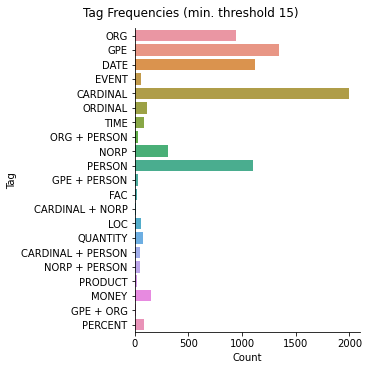

In [17]:
def get_unique_label(group:list):
    group.sort()
    return " + ".join(group)


counts = {}

for sent in results_ex2:
    for group in sent:
        lb = get_unique_label(group)
        try: counts[lb] += 1
        except KeyError: counts[lb] = 1

threshold = 15
counts = {k: v for k,v in counts.items() if v > threshold}
counts = pd.DataFrame.from_records([{'Tag': k, 'Count': v} for k,v in counts.items()])

# Plotting hist of frequencies above threshold
plot = sn.catplot(data=counts, y='Tag', x='Count', kind='bar')
plot.fig.subplots_adjust(top=0.92)
plot.fig.suptitle(f"Tag Frequencies (min. threshold {threshold})")

#### **Exercise 3**

In [18]:
# NOTE: see results of Ex2 for explanation of the list comprehension
res = evaluate([[tk for ent in sent for tk in ent] for sent in dataset['ners']], results_ex3)
pd_tbl = pd.DataFrame().from_dict(res, orient='index')
pd_tbl.round(decimals=3)

,p,r,f,s
PER,0.595,0.482,0.533,1617
MISC,0.781,0.537,0.636,702
LOC,0.753,0.705,0.728,1668
ORG,0.439,0.282,0.344,1661
total,0.634,0.496,0.557,5648


### Appendix: Testing Custom Methods

In [19]:
print("From load(): ", len(dataset['sentences']))
print("From read_corpus_conll(): ", len(read_corpus_conll('/content/data/test.txt')))

cnt = 0
for sent in read_corpus_conll('/content/data/test.txt'):
    if sent[0][0] == '-DOCSTART- -X- -X- O':
        cnt += 1
print("Count of unused rows in conll_load(): ", cnt)
print("Difference between CoNLL load() and custom load(): ", len(read_corpus_conll('/content/data/test.txt')) - len(dataset['sentences']))

From load():  3453
From read_corpus_conll():  3684
Count of unused rows in conll_load():  231
Difference between CoNLL load() and custom load():  231


In [20]:
### Retokenize + Index Conversion ###
idx = 132
doc = nlp(dataset['sentences'][idx])
sent, idx_table = retokenize(doc)
print(sent)
print({doc[k].text: sent[v] for k,v in  idx_table.items()})

[('6-0-32-2', 'O'), ('(', 'O'), ('2w', 'O'), (',', 'O'), ('1nb', 'O'), (')', 'O'), (',', 'O'), ('Saqlain', 'B-PER'), ('Mushtaq', 'I-PER'), ('8-0-54-2', 'O'), (',', 'O'), ('Mushtaq', 'B-PER'), ('Ahmad', 'I-PER')]
{'6': ('6-0-32-2', 'O'), '-': ('8-0-54-2', 'O'), '0': ('8-0-54-2', 'O'), '32': ('6-0-32-2', 'O'), '2': ('8-0-54-2', 'O'), '(': ('(', 'O'), '2w': ('2w', 'O'), ',': (',', 'O'), '1nb': ('1nb', 'O'), ')': (')', 'O'), 'Saqlain': ('Saqlain', 'B-PER'), 'Mushtaq': ('Mushtaq', 'B-PER'), '8': ('8-0-54-2', 'O'), '54': ('8-0-54-2', 'O'), 'Ahmad': ('Ahmad', 'I-PER')}


In [21]:
### Grouping entities ###
idx = -1
doc = nlp(dataset['sentences'][idx])
print(doc)

print([[(el.text, el.ent_iob_, el.ent_type_) for el in ent] for ent in doc.ents])
print([[(el.text, el.ent_iob_, el.ent_type_) for el in noun_chunk] for noun_chunk in doc.noun_chunks])

print(results_ex2[idx])

The lanky former Leeds United defender did not make his England debut until the age of 30 but eventually won 35 caps and was a key member of the 1966 World Cup winning team with his younger brother , Bobby .
[[('Leeds', 'B', 'ORG'), ('United', 'I', 'ORG')], [('England', 'B', 'GPE')], [('the', 'B', 'DATE'), ('age', 'I', 'DATE'), ('of', 'I', 'DATE'), ('30', 'I', 'DATE')], [('35', 'B', 'CARDINAL')], [('1966', 'B', 'DATE')], [('World', 'B', 'EVENT'), ('Cup', 'I', 'EVENT')], [('Bobby', 'B', 'PERSON')]]
[[('The', 'O', ''), ('lanky', 'O', ''), ('former', 'O', ''), ('Leeds', 'B', 'ORG'), ('United', 'I', 'ORG'), ('defender', 'O', '')], [('his', 'O', ''), ('England', 'B', 'GPE')], [('the', 'B', 'DATE'), ('age', 'I', 'DATE')], [('35', 'B', 'CARDINAL'), ('caps', 'O', '')], [('a', 'O', ''), ('key', 'O', ''), ('member', 'O', '')], [('the', 'O', ''), ('1966', 'B', 'DATE'), ('World', 'B', 'EVENT'), ('Cup', 'I', 'EVENT'), ('winning', 'O', ''), ('team', 'O', '')], [('his', 'O', ''), ('younger', 'O', '')

In [22]:
### Fixing Compounds ###
sentence = "my baseball bat Betty is broken ."
# sentence = "He said a proposal last month by EU Farm Commissioner Franz Fischler to ban sheep brains ."
# sentence = dataset['sentences'][10]
doc = nlp(sentence)
print(doc)
print([[(tk.text, tk.ent_iob_ + '-' + tk.ent_type_, tk.dep_) for tk in ent] for ent in doc.ents])
print("-----------------------------")
print(*[(tk.text, tk.ent_iob_ + '-' + tk.ent_type_, tk.dep_, tk.head) for tk in doc], sep='\n')
print("-----------------------------")

print(fix_compounds(doc))
doc.ents[0].end

my baseball bat Betty is broken .
[[('Betty', 'B-PERSON', 'nsubjpass')]]
-----------------------------
('my', 'O-', 'poss', bat)
('baseball', 'O-', 'compound', bat)
('bat', 'O-', 'compound', Betty)
('Betty', 'B-PERSON', 'nsubjpass', broken)
('is', 'O-', 'auxpass', broken)
('broken', 'O-', 'ROOT', broken)
('.', 'O-', 'punct', broken)
-----------------------------
[('my', 'O'), ('baseball', 'B-PER'), ('bat', 'I-PER'), ('Betty', 'B-PER'), ('is', 'O'), ('broken', 'O'), ('.', 'O')]


4

In [23]:
def alternative_fix_compounds(doc:spacy.tokens.Doc):
    parsed_sent = retokenize(doc)
    ents = list(doc.ents)

    # Setting up result sentence in CoNLL format
    res =  [[tk.text, tk.ent_iob_ + (('-' + tk.ent_type_) if tk.ent_iob_ != 'O' else '')] for tk in doc]
    
    # Cycling over the whole sentence
    for tk in doc:
        if tk.dep_ == 'compound':
            # searching for the head entity of the compound
            i = 0
            while i < len(ents):
                if tk.head in ents[i]: # performs spacy.token.Token obj. comparison, so that duplicates are avoided 
                    break
                i += 1
            
            # if compound is already in entity then does not need correction;
            # otherwise must modify iob separation of spacy
            if i < len(ents) and tk not in ents[i]:
                if tk.i < ents[i][0].i:
                    res[tk.i][1] = 'B-' + ents[i][0].ent_type_
                    for enttk in ents[i]:
                        res[enttk.i][1] = 'I-' + enttk.ent_type_
                    
                elif ents[i][0].i < tk.i < ents[i][-1].i:
                    for idx in range(tk.i + 1, ents[i][-1].i):
                        res[idx][1] = 'I-' + ents[i][0].ent_type_
                    res[tk.i][1] = 'I-' + ents[i][0].ent_type_
                else: 
                    res[tk.i][1] = 'I-' + ents[i][0].ent_type_
            

    for i in range(len(res)):
        if res[i][1] == 'O' or labelmap[res[i][1].split('-')[1]] == 'out':
            res[i][1] = 'O'
        else:
            iob, tag = res[i][1].split('-')
            res[i][1] = iob + '-' + labelmap[tag]
        res[i] = (res[i][0], res[i][1])
    return res